In [1]:
!pip3 install bitsandbytes peft trl

In [2]:
!pip install git+https://github.com/huggingface/transformers accelerate

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-gu37yikg
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-gu37yikg

  Resolved https://github.com/huggingface/transformers to commit 51d732709e5ae424e8fb6c4e58b72057a3e413c2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install qwen-vl-utils

In [4]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, AutoTokenizer,Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from datasets import load_from_disk, load_dataset
from transformers import TrainingArguments, Trainer
from pathlib import Path
from qwen_vl_utils import process_vision_info
import pandas as pd
from PIL import Image
import os
from trl import SFTConfig, SFTTrainer



In [5]:
import warnings
warnings.filterwarnings("ignore")


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
device

'cuda'

In [8]:
MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"
EPOCHS = 2
BATCH_SIZE = 2
GRADIENT_CHECKPOINTING = True #Tradeoff between memory efficenecy and compution time
USE_REENTRANT = False
OPTIM = "paged_adamw_32bit"
LEARNING_RATE = 1e-5
LR_SCHEDULER_TYPE = "constant"
LOGGING_STEPS = 1000
EVAL_STEPS = 2000
SAVE_STEPS = 2000
EVAL_STRATEGY = "steps"
SAVE_STRATEGY = "steps"
METRIC_FOR_BEST_MODEL = "eval_loss"
LOAD_BEST_MODEL_AT_END=True
MAX_GRAD_NORM = 0.3
WARMUP_STEPS = 0
DATASET_KWARGS={"skip_prepare_dataset": True}
REMOVE_UNUSED_COLUMNS = False
MAX_SEQ_LEN= 128
NUM_STEPS = ( 19654 // BATCH_SIZE) * EPOCHS
print(f"NUM_STEPS: {NUM_STEPS}")

NUM_STEPS: 19654


In [9]:
system_message = """"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer."""

def format_data(sample):
    # Erwartet in jeder Sample-Zeile:
    #   {"image": <PIL.Image>, "question": <str>, "answer": <str>}
    return [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": system_message}
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"], 
                },
                {
                    "type": "text",
                    "text": sample["question"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": sample["answer"]}
            ],
        },
    ]



In [10]:
dataset = load_dataset("flaviagiammarino/path-vqa")

README.md:   0%|          | 0.00/4.29k [00:00<?, ?B/s]

(…)-00000-of-00007-f2d0e9ef9f022d38.parquet:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

(…)-00001-of-00007-47d8e0220bf6c933.parquet:   0%|          | 0.00/81.0M [00:00<?, ?B/s]

(…)-00002-of-00007-7fb5037c4c5da7be.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

(…)-00003-of-00007-74b9b7b81cc55f90.parquet:   0%|          | 0.00/90.0M [00:00<?, ?B/s]

(…)-00004-of-00007-77eea90af4a55dce.parquet:   0%|          | 0.00/46.1M [00:00<?, ?B/s]

(…)-00005-of-00007-5332ec423be520bd.parquet:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

(…)-00006-of-00007-637a58c700b604af.parquet:   0%|          | 0.00/57.3M [00:00<?, ?B/s]

(…)-00000-of-00003-90a5518d26493b67.parquet:   0%|          | 0.00/41.3M [00:00<?, ?B/s]

(…)-00001-of-00003-cbfe947a3418595c.parquet:   0%|          | 0.00/45.7M [00:00<?, ?B/s]

(…)-00002-of-00003-9ec816895bd3bc20.parquet:   0%|          | 0.00/64.7M [00:00<?, ?B/s]

(…)-00000-of-00003-e9adadb4799f44d3.parquet:   0%|          | 0.00/41.2M [00:00<?, ?B/s]

(…)-00001-of-00003-7ea98873fc919813.parquet:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

(…)-00002-of-00003-1628308435019820.parquet:   0%|          | 0.00/69.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19654 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6259 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6719 [00:00<?, ? examples/s]

In [11]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]


In [12]:
# Lade die Liste der ausgewählten Indizes aus der Datei "list_val.txt"
indices_file = Path("validation_subset_indices.txt")
with indices_file.open("r", encoding="utf-8") as f:
    selected_indices = [int(line.strip()) for line in f if line.strip()]

# Filtere den Validierungsdatensatz mithilfe der .select()-Methode
filtered_val_dataset = val_dataset.select(selected_indices)

print("Anzahl der ausgewählten Einträge:", len(filtered_val_dataset))
val_dataset = filtered_val_dataset


Anzahl der ausgewählten Einträge: 2000


In [13]:
val_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=792x523>,
 'question': 'where does this belong to?',
 'answer': 'endocrine system'}

In [14]:
print(len(train_dataset))
print(len(val_dataset))

19654
2000


In [15]:
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 19654
})
Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 2000
})


In [16]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=CMYK size=309x272>,
 'question': 'where are liver stem cells (oval cells) located?',
 'answer': 'in the canals of hering'}

In [18]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in val_dataset]

In [19]:
train_dataset[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': '"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=CMYK size=309x272>},
   {'type': 'text',
    'text': 'where are liver stem cells (oval cells) located?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text', 'text': 'in the canals of hering'}]}]

In [20]:
sample_data = train_dataset[0]
sample_question = train_dataset[0][1]["content"][1]["text"]
sample_answer = train_dataset[0][2]["content"][0]["text"]
sample_image =train_dataset[0][1]["content"][0]["image"]

In [21]:
sample_question

'where are liver stem cells (oval cells) located?'

In [22]:
sample_answer

'in the canals of hering'

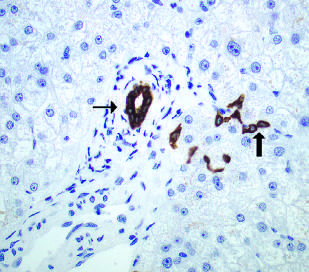

In [23]:
sample_image

In [24]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16  # Optional: torch.float16 als Fallback
    )
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto"
    )
else:
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        use_cache=False
    )

processor = Qwen2_5_VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"


config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [25]:
sample_data[0:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': '"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=CMYK size=309x272>},
   {'type': 'text',
    'text': 'where are liver stem cells (oval cells) located?'}]}]

In [26]:
def text_generator(sample_data):
    text = processor.apply_chat_template(
        sample_data[0:2], tokenize=False, add_generation_prompt=True
    )

    image_inputs = sample_data[1]["content"][0]["image"]

    inputs = processor(
        text=[text],
        images = image_inputs,
        return_tensors="pt"
    )

    inputs = inputs.to(device)

    generated_ids = model.generate(**inputs, max_new_tokens=MAX_SEQ_LEN)

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True
    )

    del inputs
    actual_answer = sample_data[2]["content"][0]["text"]
    return output_text[0], actual_answer

    print(f"Prompt: {text}")
    print("-"*30)


generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Generated Answer: system
"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer.
user
where are liver stem cells (oval cells) located?
assistant
Liver stem cells (oval cells) are located in the liver sinusoids.
Actual Answer: in the canals of hering


In [27]:
text_generator(sample_data)

('system\n"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer.\nuser\nwhere are liver stem cells (oval cells) located?\nassistant\nLiver stem cells (oval cells) are located in the liver sinusoids.',
 'in the canals of hering')

In [28]:
# Peft wurde bei beiden mllm gleich gemacht
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules= ["q_proj", "v_proj"],
    task_type="CAUSAL_LM"
)

#Trainierbare Parameter von LORA 
print(f"Before adapter parameters: {model.num_parameters()}")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

Before adapter parameters: 3754622976
trainable params: 1,843,200 || all params: 3,756,466,176 || trainable%: 0.0491


In [29]:
training_args = SFTConfig(
    dataset_kwargs=DATASET_KWARGS,
    remove_unused_columns = REMOVE_UNUSED_COLUMNS,   
)

In [30]:
# Ordner soll existieren
output_path = "./output_bs2"
os.makedirs(output_path, exist_ok=True)

In [31]:
training_args = SFTConfig(
    output_dir="./output_bs2",
    bf16=True,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    logging_steps=LOGGING_STEPS,
    eval_steps=EVAL_STEPS,
    eval_strategy=EVAL_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    max_grad_norm=MAX_GRAD_NORM,
    warmup_steps=WARMUP_STEPS,
    dataset_kwargs=DATASET_KWARGS,
    max_seq_length=MAX_SEQ_LEN,
    remove_unused_columns = REMOVE_UNUSED_COLUMNS,
    optim=OPTIM,
    report_to="tensorboard"
    
)

In [32]:
collate_sample = [train_dataset[0], train_dataset[1]]


In [33]:
def collate_fn(examples):
    """
    Daten-Kollator zum Vorbereiten eines Beispiel-Batches.

    Diese Funktion wendet das Chat-Template auf Texte an, verarbeitet die Bilder,
    tokenisiert die Eingaben und erstellt die Ziel-Labels mit korrektem Maskieren.
    """
    # 1. Chat-Template anwenden (noch ohne Tokenisierung)
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    # 2. Visuelle Eingaben vorbereiten anhand der Qwen Funktion Process Vision Info
    image_inputs = [process_vision_info(example)[0] for example in examples]

    # 3. Texte und Bilder gemeinsam tokenisieren → Tensoren mit Padding
    batch = processor(
        text=texts,
        images=image_inputs,
        return_tensors="pt", 
        padding=True, 
    )

    # 4. Labels erzeugen durch Kopieren der input_ids
    labels = batch["input_ids"].clone()

    # 5. Padding-Tokens im Label maskieren
    labels[labels == processor.tokenizer.pad_token_id] = -100

    # 6. Modellabhängig: Bild-Token-IDs bestimmen, die im Label ebenfalls maskiert werden sollen, die hier sind nur für QWen
    if isinstance(processor, Qwen2_5_VLProcessor):
        image_tokens = [151652, 151653, 151655]
    else:
        # Für andere Modelle: generischer Zugriff auf Bild-Token-ID
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]

    # 7. Bild-Token im Label ebenfalls maskieren
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100

    # 8. Labels dem Batch hinzufügen
    batch["labels"] = labels
    return batch

collated_data = collate_fn(collate_sample)
print(collated_data.keys())


KeysView({'input_ids': tensor([[151644,   8948,    198,  21608,    525,    264,   6457,  75941,   6203,
             13,   4615,   3383,    374,    311,   4226,   6457,   4755,   3118,
          21063,    389,    279,   9124,   1995,    304,    279,   3897,  75941,
           2168,     13,  25806,   1172,    389,   1128,    374,   9434,    304,
            279,   2168,   1959,    653,    537,  17188,    389,   4867,   6457,
           6540,     11,  31846,     11,    476,   9250,   1995,     13,   4615,
          14507,   1265,    387,   2805,     11,  59901,     11,    323,  77169,
          23560,     11,   1667,   8311,  56626,     13,   3155,    537,   2924,
            894,  40841,     11,  32711,     11,    476,   5107,   1467,     13,
           5443,    264,  12966,   3561,     11,   2041,  61503,     11,    323,
           5648,   6722,   7923,   7241,  77169,   2567,     13,   8278,    470,
            279,   4734,   4226,     13, 151645,    198, 151644,    872,    198,
     

In [34]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [35]:
print("-"*30)
print("Initial Evaluation")
metric = trainer.evaluate()
print(metric)
print("-"*30)

print("Training")
trainer.train()
print("-"*30)

------------------------------
Initial Evaluation


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


{'eval_loss': 4.493781566619873, 'eval_model_preparation_time': 0.0036, 'eval_runtime': 400.7948, 'eval_samples_per_second': 4.99, 'eval_steps_per_second': 2.495}
------------------------------
Training


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss,Model Preparation Time
2000,0.270800,0.250815,0.003600
4000,0.240200,0.235483,0.003600
6000,0.233200,0.228653,0.003600
8000,0.228900,0.222609,0.003600
10000,0.222300,0.219966,0.003600
12000,0.224300,0.216965,0.003600
14000,0.215200,0.213994,0.003600
16000,0.218900,0.212580,0.003600
18000,0.214100,0.210615,0.003600


------------------------------


In [36]:
trainer.save_model(training_args.output_dir)

In [37]:
import gc
import time


def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 4.54 GB


In [38]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16  # Optional: torch.float16 als Fallback
    )
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(  # oder korrektes Modell
        MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto",
        use_cache=True
    )
else:
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        use_cache=True
    )

processor = Qwen2_5_VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [39]:
print(f"Before adapter parameters: {model.num_parameters()}")
model.load_adapter("./output_bs2")
print(f"After adapter parameters: {model.num_parameters()}")

Before adapter parameters: 3754622976
After adapter parameters: 3756466176


In [40]:
generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Generated Answer: system
"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer.
user
where are liver stem cells (oval cells) located?
assistant
in the perisinusoidal space
Actual Answer: in the canals of hering


In [41]:
import torch
print(torch.cuda.device_count())


1


In [42]:
import torch
torch.cuda.empty_cache()
